In [1]:
%matplotlib inline
import numpy as np
import networkx as nx

In [2]:
import matplotlib.pyplot as plt 
from matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg'

In [3]:
from qiskit import Aer, QuantumRegister, ClassicalRegister,QuantumCircuit,execute
from qiskit.visualization import plot_histogram

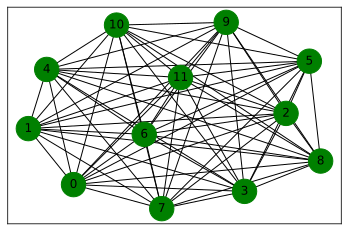

In [17]:
n     = 12
V     = np.arange(0,n,1)
E     =[(i,j,1.0)for i in range(n) for j in range(n) if i!=j] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

colors       = ['green' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

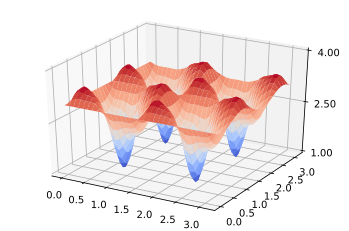


OPTIMAL PARAMETERS

The maximal expectation value is:  M1 = 3.431359590000791
This is attained for gamma = %.03f and beta = (1.9000000000000001, 0.2)


In [19]:
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)


result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;


fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

print('\nOPTIMAL PARAMETERS\n')
print(f'The maximal expectation value is:  M1 = {np.amax(F1)}')
print(f'This is attained for gamma = %.03f and beta = {gamma,beta}')


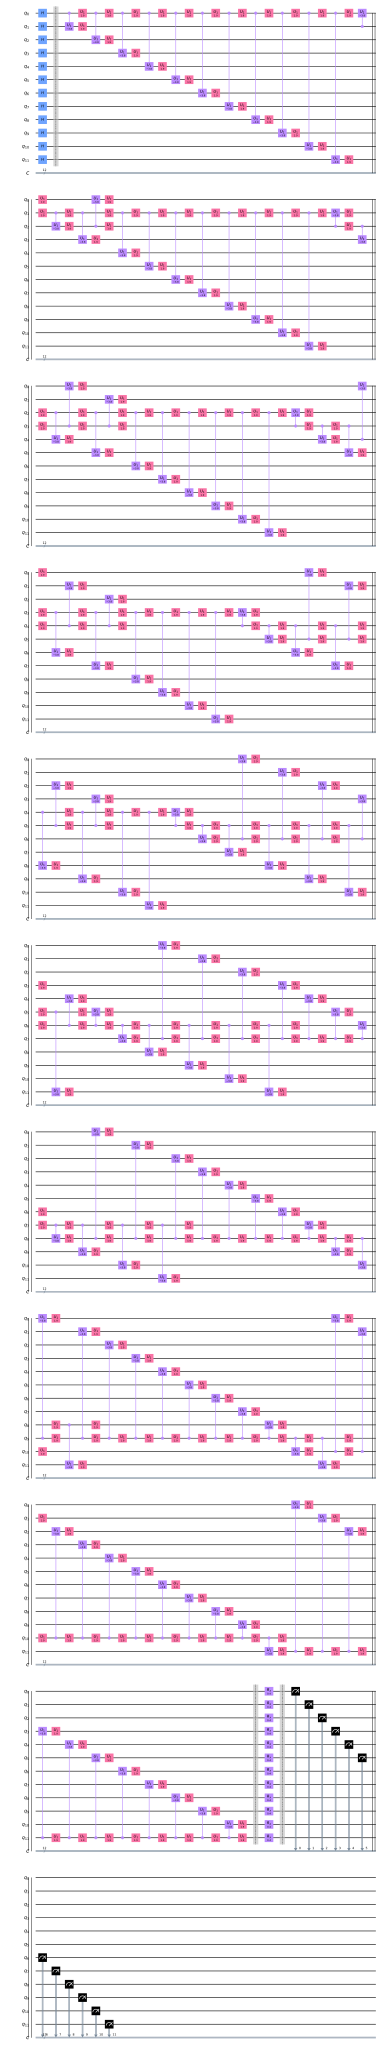

In [6]:

QAOA = QuantumCircuit(len(V), len(V))


QAOA.h(range(len(V)))
QAOA.barrier()


for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)

QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))


QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

QAOA.draw(output='mpl')


In [7]:
def costfunction(x,G):
    E = G.edges()
    if(len(x)!=len(G.nodes())):
        return np.nan
    C = 0
    for index in E:
        e1 = index[0]
        e2 = index[1]
        w = G[e1][e2]['weight']
        C += w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

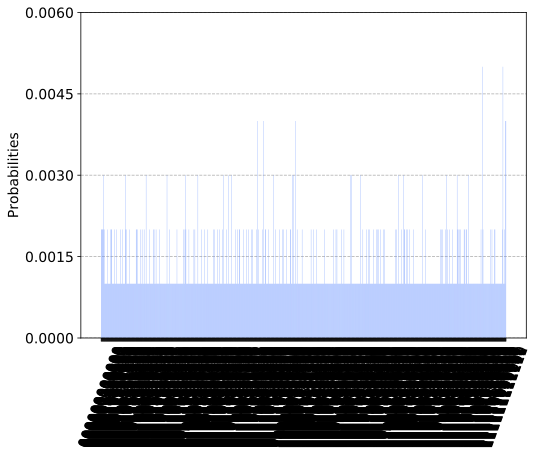

In [8]:
backend = Aer.get_backend('qasm_simulator')
shots = 1000
simulate = execute(QAOA,backend=backend,shots=shots)
result = simulate.result()
plot_histogram(result.get_counts(),figsize = (8,6), bar_labels=False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 32.46 while the true value is M1 = 3.43 

The approximate solution is x* = 100101011010 with C(x*) = 36 

The cost function is distributed as: 



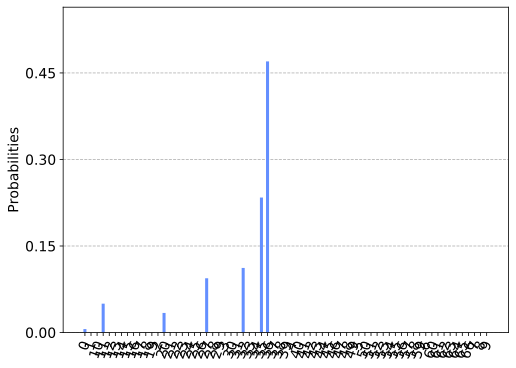

In [9]:
counts = result.get_counts()
avg = 0
maxi = [0,0]
hist = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)
    
for sample in list(counts.keys()):
    
    x = [int(num) for num in list(sample)]
    tmp_eng = costfunction(x,G)
    
    avg += counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    if(maxi[1]<tmp_eng):
        maxi[0] = sample
        maxi[1] = tmp_eng
        
    M1_sampled = avg/shots
    
    
print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (maxi[0],maxi[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)